In [1]:
%matplotlib inline 


import numpy as np #To use functions or constants that are in the NumPy module, type np.function_name. EG: np.pi is pi
import numpy.random as nprd #This imports random number generation functions
import scipy as sp #SciPy has lots of useful numerical methods, so we don't have to write them
import scipy.linalg as spla #This imports the sub-module containing linear algebra methods
import matplotlib.pyplot as plt #This will let us display images nicely
import cv2
#import pandas as pd 
from scipy import ndimage
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering


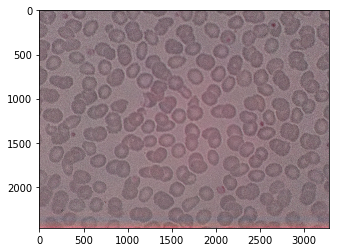

In [2]:
img = cv2.imread('X:\\Physics\\ResearchProjects\\RWBowman\\RC-PH1201\Malaria_Diagnostic_Microscopy\\Project\\SAMBa Reading Project MDuff\\Malaria-Imaging-Code\\Full Images\\0_0.jpg')
plt.imshow(img)
plt.show()



In [3]:
def hough(img): #Hough circle transform 
   
    try:
     
        img = cv2.medianBlur(img,7)
        circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,param1=30,param2=15,minRadius=60,maxRadius=90)
        store=np.zeros(np.shape(circles[0,:])[0])+1
        for n in range(np.shape(store)[0]):
            i=circles[0,n]
            for j in range(n):
                if store[j]==1:
                    other=circles[0,j]
                    if (other[0]-i[0])**2+(other[1]-i[1])**2 < 100**2:
                        store[n]=0
        #                 print(other[0],i[0])
        #                 print(other[1],i[1])
        #                 print((other[0]-i[0]),(other[1]-i[1]) )
        #                 print((other[0]-i[0])**2,(other[1]-i[1])**2 )



        store=np.array(store, dtype=np.bool)
        circles2=circles[0,:]
        circles2= circles2[store,:]
        circles2 = np.uint16(np.around(circles2))


        return(circles2)
    except Exception:# NEED TO SORT THIS!!!!!!!!!!!!!!!!
        return()

In [4]:
def small_thing_removal(img,min_area):
    label_img, cc_num = ndimage.label(img)
    CC = ndimage.find_objects(img)
    cc_areas = ndimage.sum(img, label_img, range(cc_num+1))
    area_mask = (cc_areas < min_area)
    img[area_mask[label_img]] = 0
    return(np.uint8(img))
    
def crop_minAreaRect(img, rect):

    # rotate img
    angle = rect[2]
    rows,cols = img.shape[0], img.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    img_rot = cv2.warpAffine(img,M,(cols,rows))

    # rotate bounding box
    rect0 = (rect[0], rect[1], 0.0)
    box = cv2.boxPoints(rect)
    pts = np.int0(cv2.transform(np.array([box]), M))[0]    
    pts[pts < 0] = 0

    # crop
    img_crop = img_rot[pts[1][1]:pts[0][1], 
                       pts[1][0]:pts[2][0]]

    return img_crop

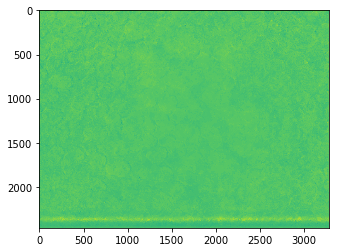

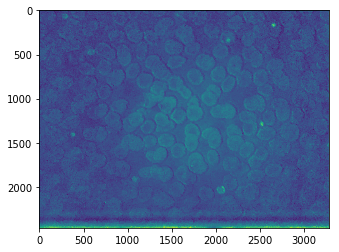

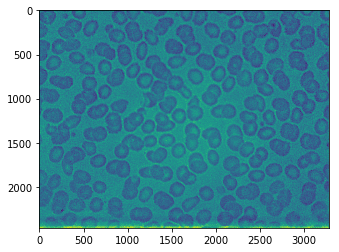

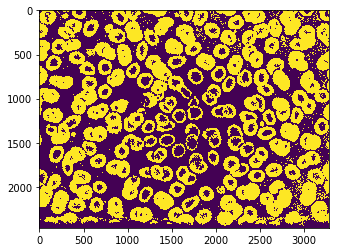

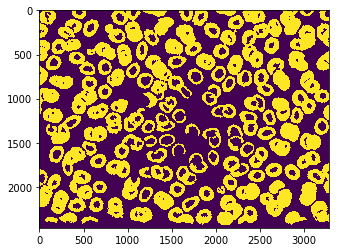

In [5]:
## Convert to HSV colour space 
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_h=img_hsv[:,:,0]
img_s=img_hsv[:,:,1]
img_v=img_hsv[:,:,2]

plt.imshow(img_h)
plt.show()
plt.imshow(img_s)
plt.show()
plt.imshow(img_v)
plt.show()

blur = cv2.GaussianBlur(img_v,(3,3),0)
ret_v,th_v = cv2.threshold(255-blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(th_v)
plt.show()

kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
opening_v = cv2.morphologyEx(th_v, cv2.MORPH_OPEN, kernel1)
opening_v=small_thing_removal(opening_v,5000*255)
kernel2= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
closing_v = cv2.morphologyEx(opening_v, cv2.MORPH_CLOSE, kernel1)
plt.imshow(closing_v)
plt.show()


In [19]:
#Seperating overlapping objects


def find_sure_fg(img):
        
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    img = cv2.medianBlur(img,5)
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                                param1=30,param2=15,minRadius=60,maxRadius=90)
    
    circles = np.uint16(np.around(circles))
    sure_fg=np.zeros(np.shape(img))
    #print(circles)
    for i in circles[0,:]:
          # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        cv2.circle(sure_fg,(i[0],i[1]),2,255,50)
    sure_fg = np.uint8(sure_fg)
#     plt.imshow(cimg)
#     plt.show()

    return(sure_fg)
    
def seperate_overlapping(img,cnt, x,y,w,h):
    #Hough and watershed
    img_mult_bw= img
    img2=img
    cimg = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)


    kernel = np.ones((5,5),np.float32)/25
    img_mult_bw = cv2.filter2D(img_mult_bw,-1,kernel)
    # plt.imshow(img_mult_bw)
    # plt.show()

    ret, thresh = cv2.threshold(img_mult_bw,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # plt.imshow(thresh)
    # plt.show()

    # noise removal
    kernel = kernel1
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)
    # plt.imshow(opening)
    # plt.show()

    # sure background area
    sure_bg=np.zeros(np.shape(img_v))
    cv2.fillConvexPoly(sure_bg,cnt, 255)
    sure_bg=sure_bg[int(y):int(y+h),int(x):int(x+w)]
    sure_bg = np.uint8(sure_bg)
    # plt.imshow(sure_bg)
    # plt.show()

    # Finding sure foreground area
    sure_fg=find_sure_fg(img2)
    sure_fg[sure_bg==0]=0
    # plt.imshow(sure_fg)
    # plt.show()


    # Finding unknown region

    unknown = cv2.subtract(sure_bg,sure_fg)
    # plt.imshow(unknown)
    # plt.show()

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    # plt.imshow(markers)
    # plt.show()

    markers = cv2.watershed(cimg,markers)
    # img_mult_bw[markers == -1] = 0
    # plt.imshow(img_mult_bw)
    # plt.show()

    # plt.imshow(markers)
    # plt.show()

    #Draw boxes on original image 
    Number_cells_found=np.max(markers)-1
    print(Number_cells_found)
    Table=np.zeros((Number_cells_found, 4))
    for i in range(1,Number_cells_found+1):
        found_cell=np.zeros(np.shape(img_mult_bw))
        found_cell[markers==i]=255
        found_cell=np.uint8(found_cell)
        ret,thresh = cv2.threshold(found_cell,127,255,0)
        im2,contours,hierarchy = cv2.findContours(255-thresh, 1, 2)
        cnt=contours[0]
        x,y,w,h = cv2.boundingRect(cnt)
        area=cv2.contourArea(cnt)
        if 25000>area>6000:
            cv2.rectangle(img_mult_bw,(x,y),(x+w,y+h),255,2)
            Table[i-1,:]=cv2.boundingRect(cnt)
    plt.imshow(img_mult_bw)
    plt.show()
    return(Table)

C:\Users\magd21\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


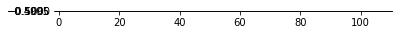

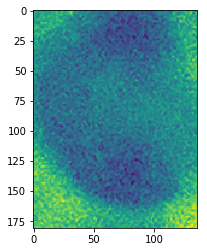

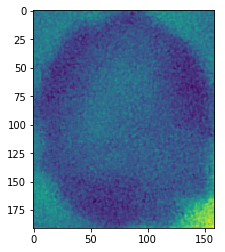

2


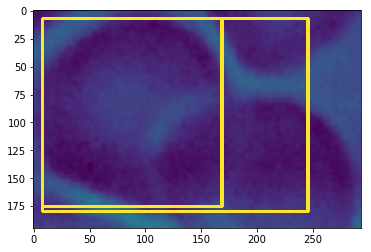

2


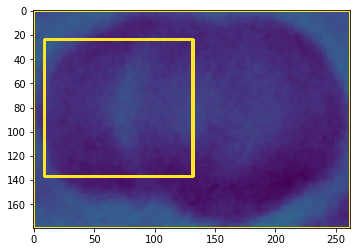

2


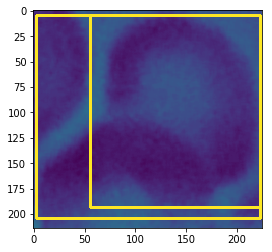

1


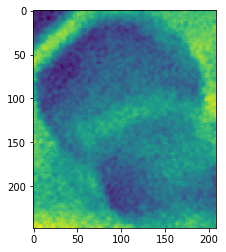

1


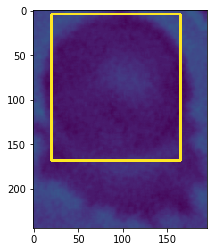

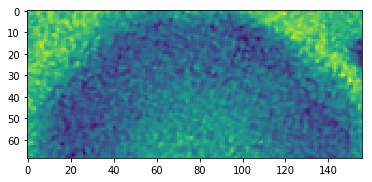

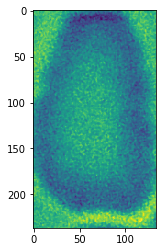

3


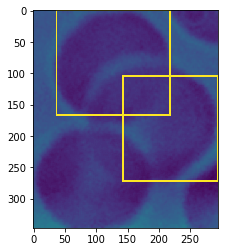

2


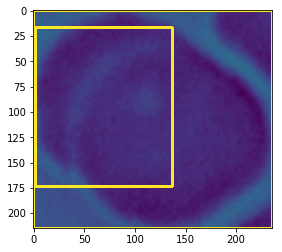

1


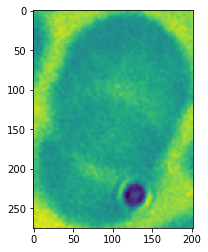

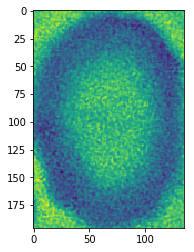

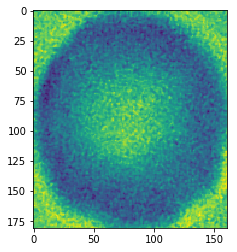

2


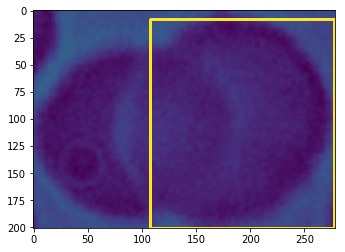

2


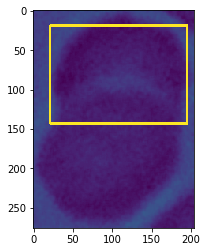

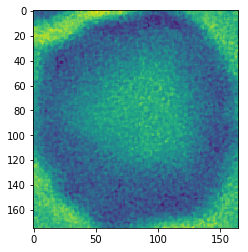

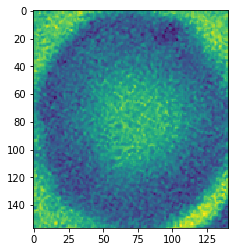

4


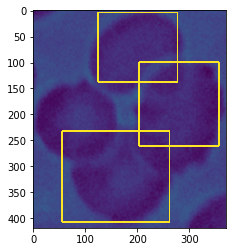

2


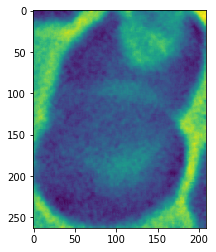

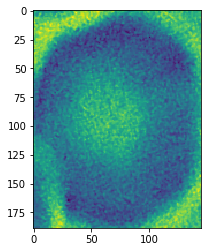

1


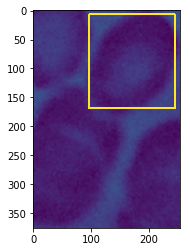

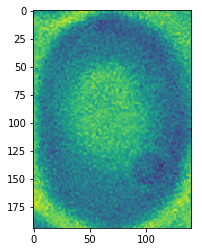

4


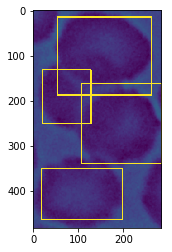

1


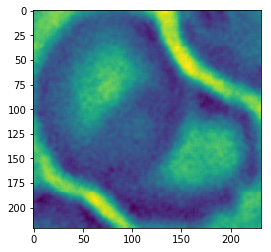

2


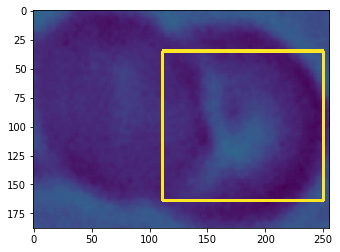

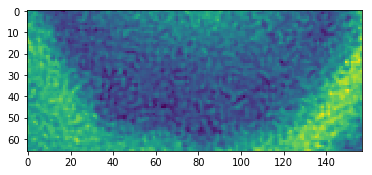

3


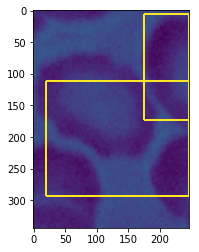

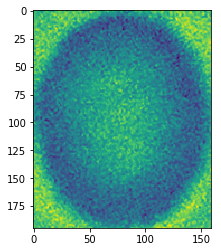

2


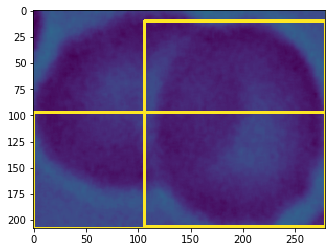

6


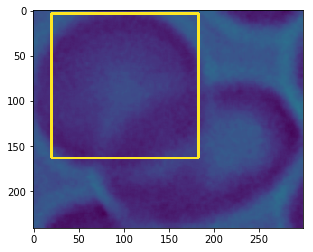

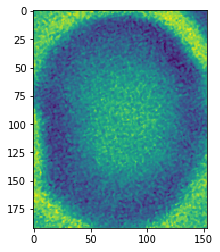

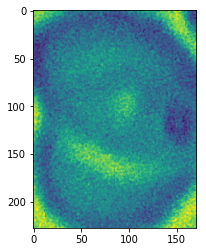

1


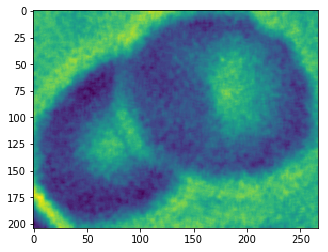

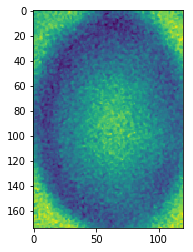

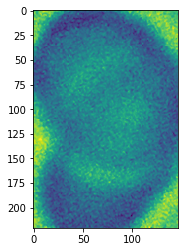

1


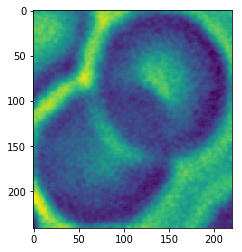

2


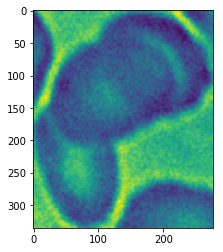

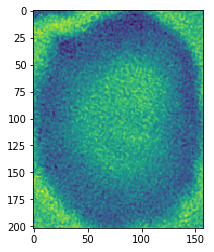

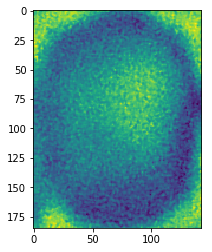

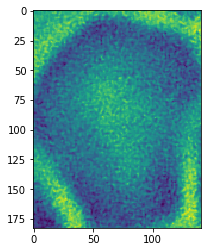

1


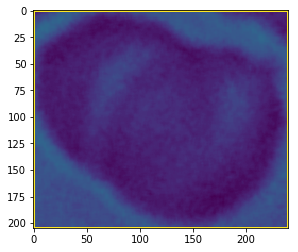

2


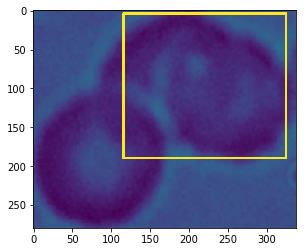

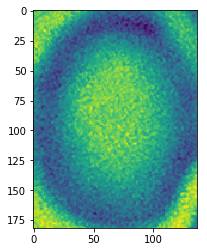

1


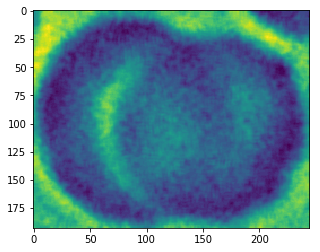

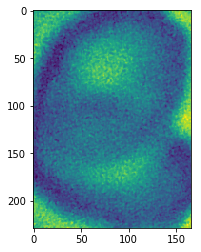

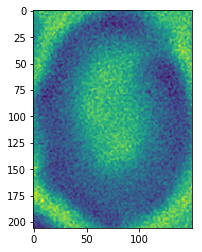

2


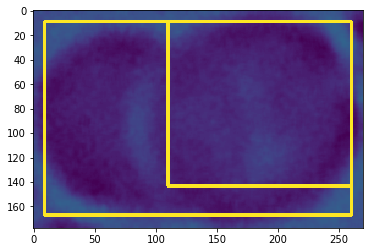

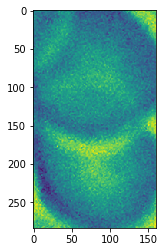

1


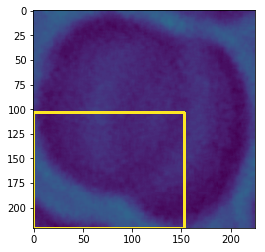

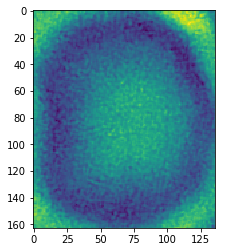

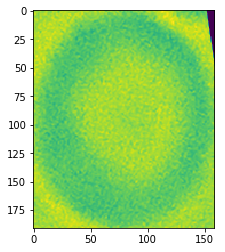

3


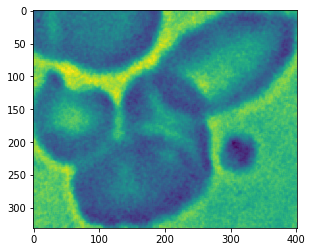

1


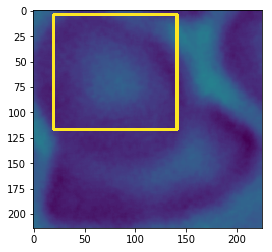

1


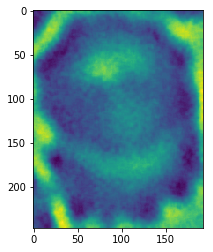

2


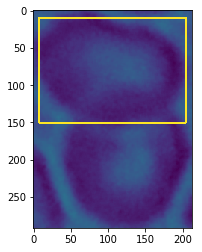

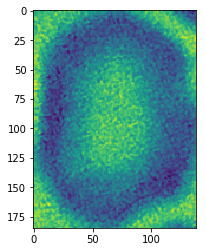

2


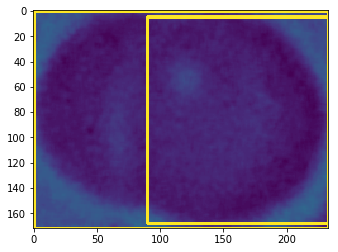

2


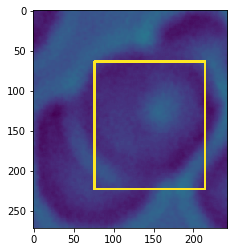

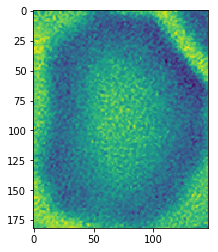

2


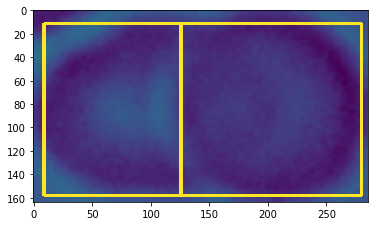

1


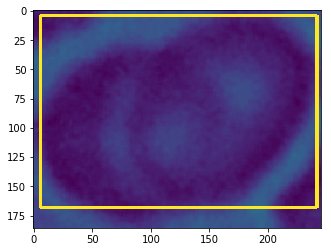

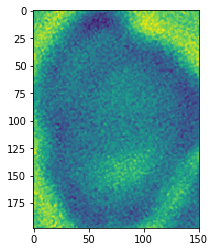

1


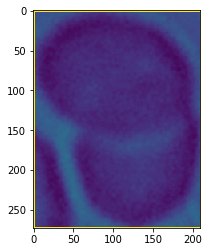

1


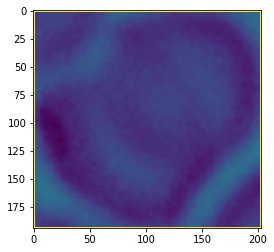

2


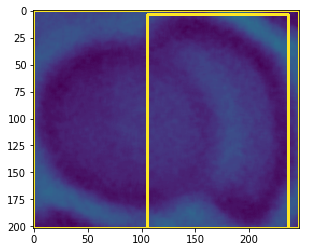

2


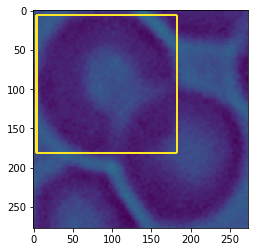

1


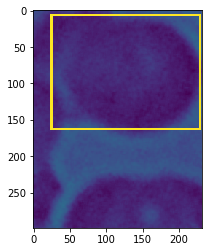

3


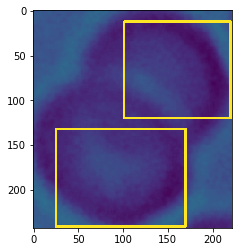

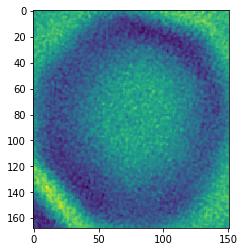

3


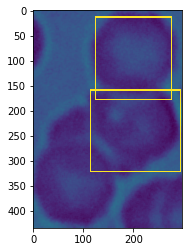

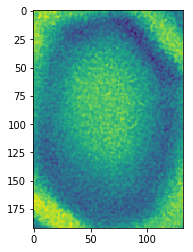

1


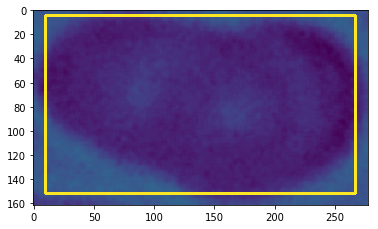

1


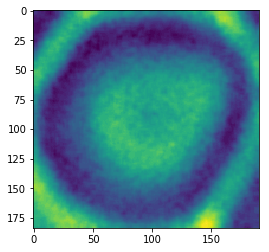

5


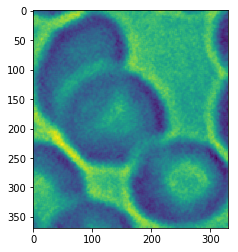

2


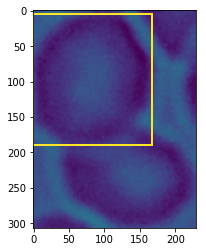

1


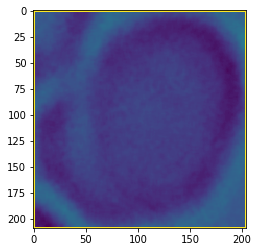

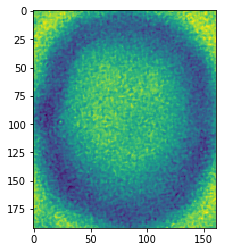

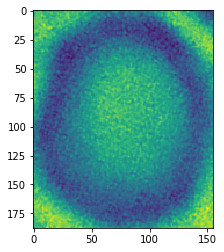

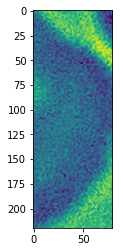

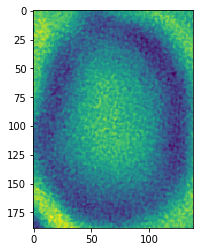

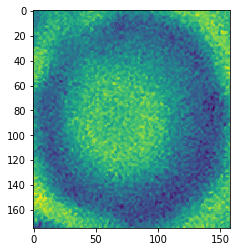

2


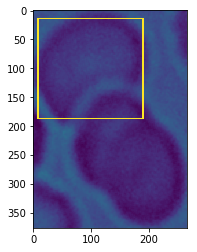

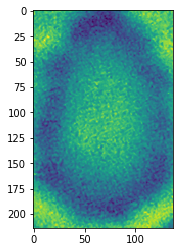

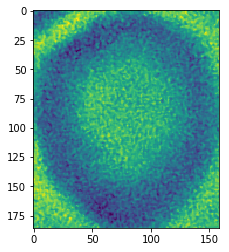

2


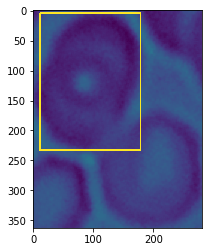

7


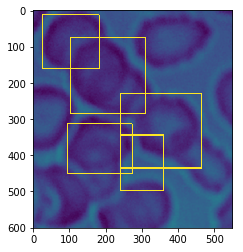

1


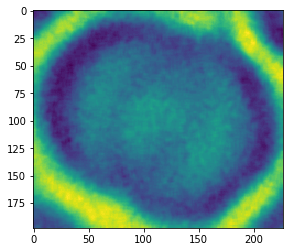

2


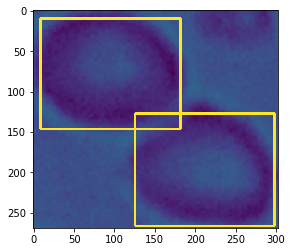

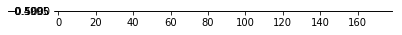

1


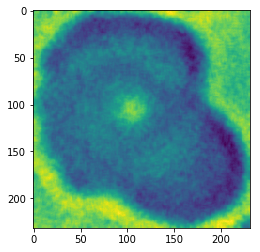

1


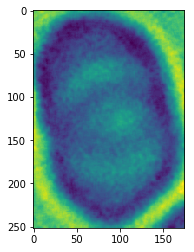

1


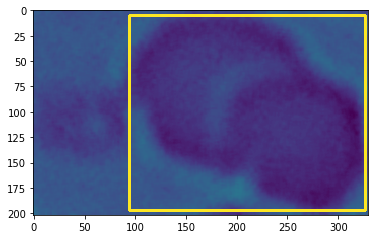

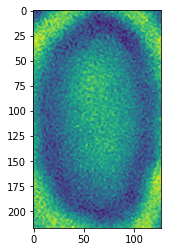

C:\Users\magd21\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))


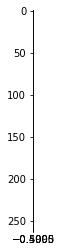

2


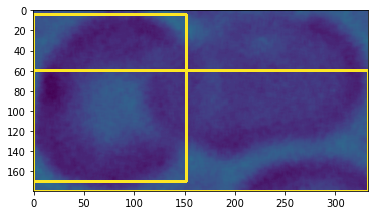

1


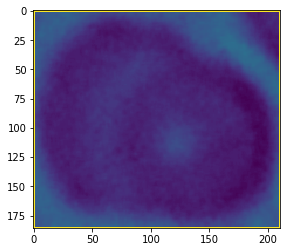

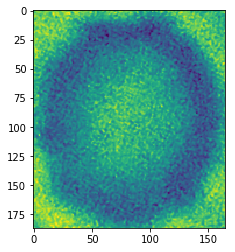

2


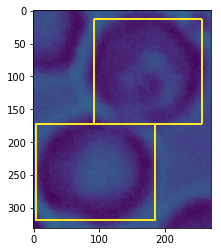

1


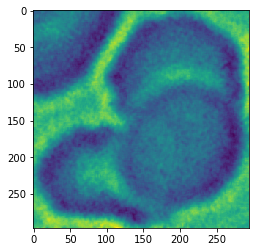

3


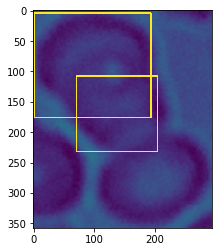

1


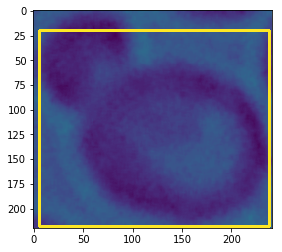

1


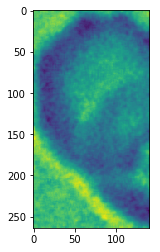

1


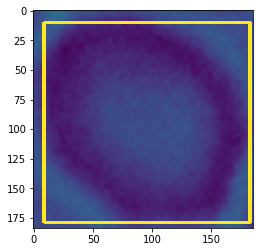

1


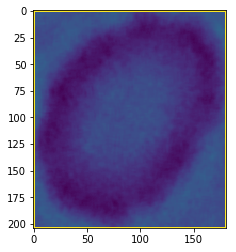

5


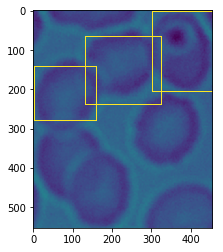

2


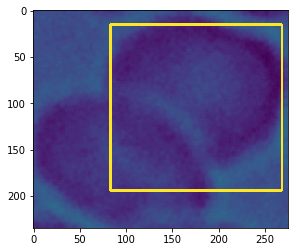

2


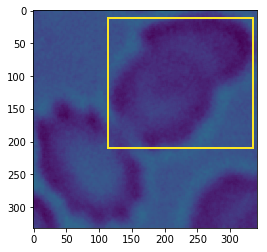

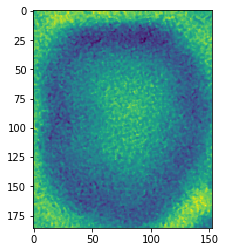

2


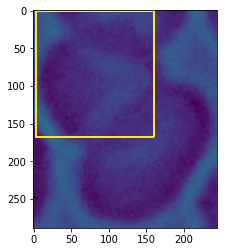

2


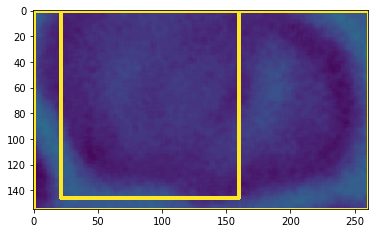

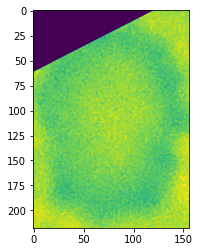

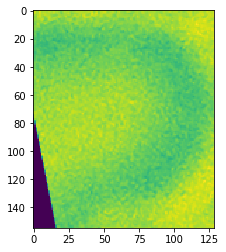

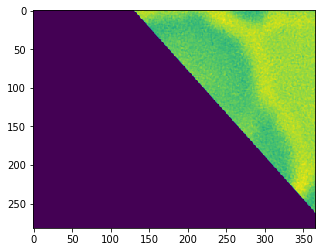

4


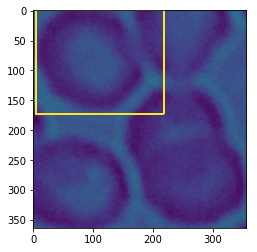

1


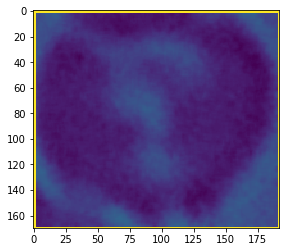

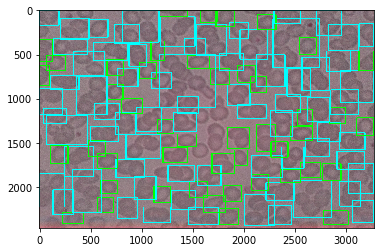

In [20]:

pictures = {}
multidict={}
contourdict={}
pointdict={}
number=0
contours = cv2.findContours(closing_v, 1, 2)
for i in range(np.shape(contours[1])[0]):
    cnt = contours[1][i]
    x,y,w,h = cv2.boundingRect(cnt)

    area=cv2.contourArea(cnt)
    

 
    if 25000>area>12000:
        ellipse = cv2.fitEllipse(cnt)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),10)
        img_new=crop_minAreaRect(img_v, ellipse)  #  cv2.imwrite ('H:\\dos\\Reading Courses\\Malaria Imaging\\cropped_images\\0_1_crop'+str(i)+'.tiff',  img_new)
        pictures[number] = img_new
        number=number+1
        plt.imshow(img_new)
        plt.show()
    elif area>25000:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),10)
        #print(x,y)
        img_new=img_v[int(y):int(y+h),int(x):int(x+w)]
    
        boxes= seperate_overlapping(img_new, cnt, x,y,w,h)
        


plt.imshow(img,aspect='auto')
plt.show()